In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-29 13:31:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-29 13:31:05 (84.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
#!pip install sktime
import helper_functions as hf
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
def mean_absolute_scaled_error(y_true,y_pred):
  mae = tf.math.reduce_mean(tf.abs(y_true - y_pred))
  naive_mae = tf.math.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / naive_mae

def plot_timeseries_data(timestamp,values,format=".",start=0,end=None,label=None):
  """
  Plot timeseries data with label

  Parameters:
  --------------
  timestamp: the array of timestamps
  values: the array of values across timestamps
  format: the style of format
  start: start ind of timestamp/value
  end: end ind of timestamp/value
  label: the label for the plot
  """

  plt.plot(timestamp[start:end],values[start:end],format,label=label)
  plt.title("BTC Closing Price Trend within 8 years data")
  plt.xlabel("Day")
  plt.ylabel("Price")
  if label:
    plt.legend()
  plt.grid(True)

def evaluate_preds(y_true,y_pred):
  """
  Description:
  ------------------
  General calculation for metrics. if there is over 1 axis for the actual/prediction label
  reduce to scaler value with average aggregation performed.
  """
  y_true = tf.cast(y_true,dtype=tf.dtypes.float64)
  y_pred = tf.cast(y_pred,dtype=tf.dtypes.float64)

  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = np.sqrt(tf.keras.metrics.mean_squared_error(y_true,y_pred))
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  if y_true.ndim > 1 or len(y_pred.shape) > 1 : # reduce higher axis to scaler
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse).numpy()
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
                          

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse,
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }
  
# can follow the iinput/output pattern from sklearn.model_selection.train_test_split
def make_train_test_split(windows,labels,test_split=0.2):
  split_ind = int((1-test_split)*len(windows))
  train_windows,train_labels = windows[:split_ind],labels[:split_ind]
  test_windows,test_labels = windows[split_ind:],labels[split_ind:]
  return train_windows,train_labels,test_windows,test_labels
## Model checkpooint
import os
def make_model_checkpoint(model_name,save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_name,save_path),
                                                      verbose=0,
                                                      save_best_only=True,)
def make_preds(model,input):
  return tf.squeeze(model.predict(input))
# numpy operation is faster
def create_windows(data,window_size = 7,horizon = 1):
  
  # the index you want to access the data for each window
  windows_step = np.arange(window_size+horizon)

  # index matrix : determine how many windows there
  # perform element-wise operation 
  windows_indexs =  tf.expand_dims(np.arange(len(data)-(window_size+horizon)+1),axis=1) + windows_step


  # access the data
  x = data[windows_indexs]

  windows_data,horizon_label = get_labelled_windows(x,horizon)

  return windows_data,horizon_label
WINDOW_SIZE = 7
HORIZON_SIZE = 1
def get_labelled_windows(data,HORIZON_SIZE = 1):
  """
  Parameters:
  ----------------
  data: should be two dimension matrix

  Returns:
  ----------------
  Return window data for input, horizon data for output
  """
 
  return data[:,:-1*HORIZON_SIZE], data[:,-1*HORIZON_SIZE:]


## 2022.07.15 - TimeSeries Part 1 - BitPred
- https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

### Introduction
- TimeSeries Problem:
  - classification: 
    - the discrete value of each timestamp in the future. like anomaly detection on time series data
    - the category of whole bunch timeseries data 
  - Forcasting:
    - the constinuous value in the future
  - the lognger you predict, the larger loss you have
- How to evaluate the problem is suitable for time-series data
  - have many features/factors that impact your target
  - have long data (have much time-series data)
  - Similar pattern between past and future(shot-term win over long-term)
  - no random massive impact
  - the forcast won't impact what we're trying to forcast
- Termonology:
  - Window: the interval that feed into the input of time-series model
    - is how many timestamp of input you want to feed into the model
    - is not related the number of feature ( univariate or multivariate
  - Horizon: include how many time-stamp of data you want to predict
  - Window and Horizon size depends on the problem you have
    - many to one problem
    - many to many problem asynchronous
- Patterns of Time-series
  - Trend: increase/decrease in long-term
  - Seasonal: fixed period, regular rise and down
  - cyclic: unfixed period, inregular rise and down. have more variety then seasonal
  - Nopattern: not suitable to fit the time-series pattern because no observable pattern from the past.
  

### Download & Prepare Data
- usually will has less data than typical neural network problem
  - 因為可以玩轉時間, can increase/decreate datetime accuracy

In [4]:
# Download the dataset
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
data = pd.read_csv(
    "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
    ,parse_dates=["Date"], # convert Date col to datetime type
    index_col=["Date"])# let Date as index
data = data.rename({data.columns[1]:"Price"},axis=1)["Price"].to_frame()

--2022-07-29 13:31:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-07-29 13:31:08 (11.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
data.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
len(data)

2787

In [ ]:
### Using csv to load the data
import csv
import datetime as dt

btc_date = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv","r") as f:
  csv_reader = csv.reader(f)
  next(csv_reader)
  for line in csv_reader:
    btc_date.append(dt.datetime.strptime(line[1],"%Y-%m-%d"))
    btc_price.append(float(line[2]))

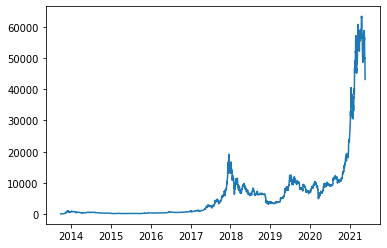

In [ ]:
plt.plot(btc_date,btc_price)

### Split the Data
- cannot random split time-series data
  - if random split time-series data. the dist. between training and testing is similar, the model perforrmance will perform over than expected due to data leakage
- you cannot put the feature 'actual' data to pred next value
   - because that actual data is out of your training recongizaation. so you won't know that, 
   - only yoou can do iis use predicted data to pred next value for val/testing dataset and use actual to calculate loss or metrics
- so should split train/val/test based on the time-series

In [ ]:
### the right way to split the train and testing
prop = 0.8
split_ind = int(prop*data.shape[0])
X_train, y_train = data.index.values[:split_ind], data["Price"].values[:split_ind]
X_test, y_test = data.index.values[split_ind:], data["Price"].values[split_ind:]

In [ ]:
X_train.shape[0]+X_test.shape[0] == data.shape[0]

True

In [ ]:
def plot_timeseries_data(timestamp,values,format=".",start=0,end=None,label=None):
  """
  Plot timeseries data with label

  Parameters:
  --------------
  timestamp: the array of timestamps
  values: the array of values across timestamps
  format: the style of format
  start: start ind of timestamp/value
  end: end ind of timestamp/value
  label: the label for the plot
  """

  plt.plot(timestamp[start:end],values[start:end],format,label=label)
  plt.title("BTC Closing Price Trend within 8 years data")
  plt.xlabel("Day")
  plt.ylabel("Price")
  if label:
    plt.legend()
  plt.grid(True)

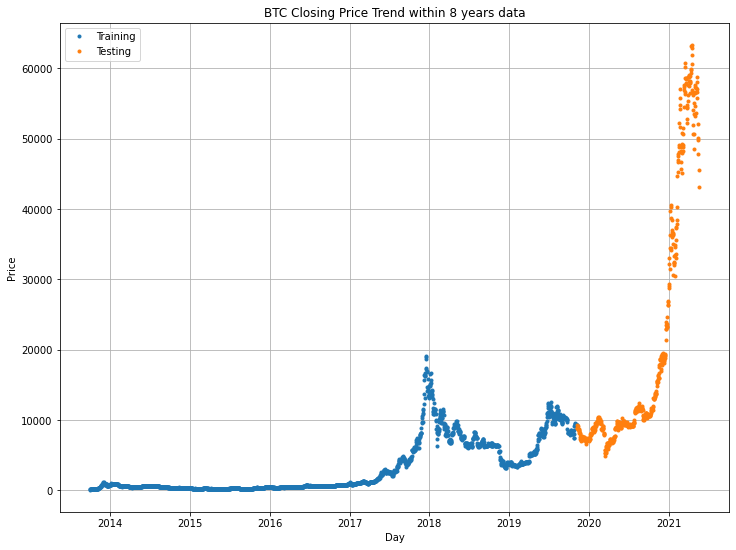

In [ ]:
plt.figure(figsize=(12,9))
plot_timeseries_data(X_train,y_train,label="Training")
plot_timeseries_data(X_test,y_test,label="Testing")

### Modeling - Baseline naive model
- timestamp(t-1) data will be used and assigned to the predicted value of timstamp(t) data 
- Hard to beat the baseline moodel but the prediction is really limited. because can only predict target on next timestamp.

$$\hat{y}_{t}={y}_{t-1}$$

In [ ]:
naive_prediction = y_test[:-1]
y_test[-10:],naive_prediction[-10:],y_test[-11]

(array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]),
 57107.1206718864)

In [ ]:
model_0_result = evaluate_preds(y_test[1:],naive_prediction)
model_0_result

{'mae': 567.9802273457541,
 'mape': 2.516524929982267,
 'mase': 0.9995699939182624,
 'mse': 1147547.1250238959,
 'rmse': 1071.2362601330744}

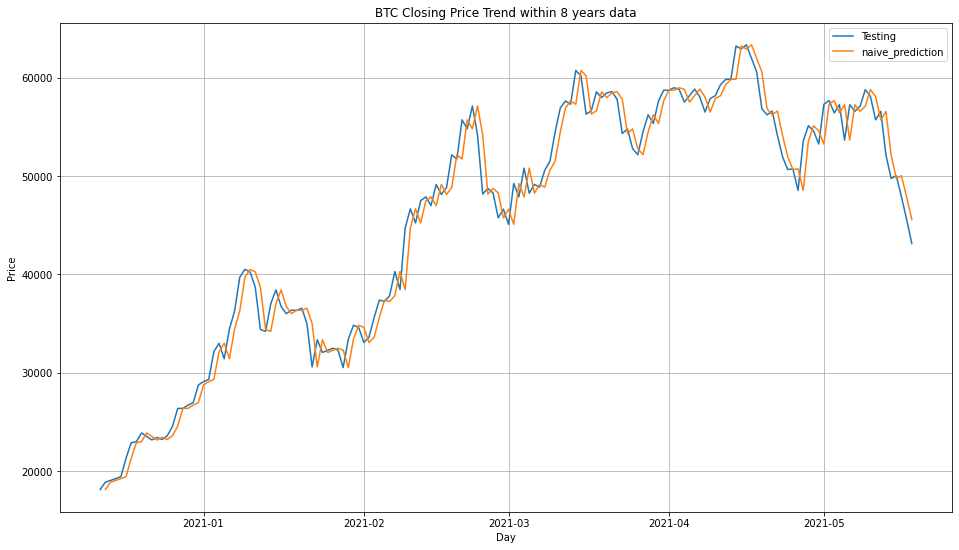

In [ ]:
plt.figure(figsize=(16,9))
#plot_timeseries_data(X_train,y_train,label="Training")
plot_timeseries_data(X_test,y_test,start=400,format="-",label="Testing")
plot_timeseries_data(X_test[1:],naive_prediction,format="-",start=400,label="naive_prediction")

### Metrics
- the forcast problem is like regression problem because we are predicting the value
- MAE,MSE,RMSE
- 專門for forcast 的 metrics: MAPE, MASE
  - MAPE is not recommended 
    - symmetric absoulte percentage error
  - MASE is recommended:  (MAE+scaled)
    - if scaled error > 1 => the forcast is worse than naive forecast
    - if scaled error < 1 => the forcast is better than naive forecast
    - if scaled error ==1 => the forecast is equal than naive forcast. so this model will be naive forcast
    - https://en.wikipedia.org/wiki/Mean_absolute_scaled_error

In [ ]:
def mean_absolute_scaled_error(y_true,y_pred):
  mae = tf.math.reduce_mean(tf.abs(y_true - y_pred))
  naive_mae = tf.math.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / naive_mae

In [ ]:
mean_absolute_scaled_error(y_test[1:],naive_prediction)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [ ]:
def evaluate_preds(y_true,y_pred):
  """
  Description:
  ------------------
  General calculation for metrics. if there is over 1 axis for the actual/prediction label
  reduce to scaler value with average aggregation performed.
  """
  y_true = tf.cast(y_true,dtype=tf.dtypes.float64)
  y_pred = tf.cast(y_pred,dtype=tf.dtypes.float64)

  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = np.sqrt(tf.keras.metrics.mean_squared_error(y_true,y_pred))
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  if y_true.ndim > 1: # reduce higher axis to scaler
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse).numpy()
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
                          

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse,
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }


In [ ]:
evaluate_preds(y_test[1:],naive_prediction)

{'mae': 567.9802273457541,
 'mape': 2.516524929982267,
 'mase': 0.9995699939182624,
 'mse': 1147547.1250238959,
 'rmse': 1071.2362601330744}

## 2022.07.17 - TimeSeries Part 2 - BitPred

### Feature Engineering - Create Windows Input and Horizon
- Windows size = 7
- Horizon = 1
- Steps:
  - determine the how many of windows the input need
  - perform element wise ooperation to generate index matrix
  - mapping index matrix to data matrix
  - split windows and horizon
  - split training and testing based on the sequential test split

In [ ]:
y_train.shape[0]

2229

In [ ]:
WINDOW_SIZE = 7
HORIZON_SIZE = 1
def get_labelled_windows(data,HORIZON_SIZE = 1):
  """
  Parameters:
  ----------------
  data: should be two dimension matrix

  Returns:
  ----------------
  Return window data for input, horizon data for output
  """
 
  return data[:,:-1*HORIZON_SIZE], data[:,-1*HORIZON_SIZE:]

In [ ]:
get_labelled_windows(tf.expand_dims(tf.range(8)+1,axis=0))

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [ ]:
# can use tensorflow function
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array
from tensorflow.keras.utils import timeseries_dataset_from_array

In [ ]:
# numpy operation is faster
def create_windows(data,window_size = 7,horizon = 1):
  
  # the index you want to access the data for each window
  windows_step = np.arange(window_size+horizon)

  # index matrix : determine how many windows there
  # perform element-wise operation 
  windows_indexs =  tf.expand_dims(np.arange(len(data)-(window_size+horizon)+1),axis=1) + windows_step


  # access the data
  x = data[windows_indexs]

  windows_data,horizon_label = get_labelled_windows(x,horizon)

  return windows_data,horizon_label


In [ ]:
full_windows,full_horizon = create_windows(data.values.flatten(),WINDOW_SIZE,HORIZON_SIZE)
for i in range(-1,-4,-1):
  print(f"{full_windows[i]} -> {full_horizon[i]}")

[55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> [43144.47129086]
[58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> [45604.61575361]
[58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> [47885.62525472]


### Train Test Split

In [ ]:
# can follow the iinput/output pattern from sklearn.model_selection.train_test_split
def make_train_test_split(windows,labels,test_split=0.2):
  split_ind = int((1-test_split)*len(windows))
  train_windows,train_labels = windows[:split_ind],labels[:split_ind]
  test_windows,test_labels = windows[split_ind:],labels[split_ind:]
  return train_windows,train_labels,test_windows,test_labels

In [ ]:
WINDOW_SIZE = 7
HORIZON_SIZE = 1
full_windows,full_horizon = create_windows(data.values.flatten(),WINDOW_SIZE,HORIZON_SIZE)
train_windows,train_labels,test_windows,test_labels = make_train_test_split(full_windows,
                                                                            full_horizon)

In [ ]:
from tensorflow.keras.utils import timeseries_dataset_from_array

In [ ]:
raw_data = data.values.flatten()
full_dataset = timeseries_dataset_from_array(raw_data,targets=raw_data[7:],sequence_length=7,batch_size=128)
split_size = int(0.8*len(full_dataset))
training_dataset = full_dataset.take(split_size).prefetch(tf.data.AUTOTUNE)
testing_dataset = full_dataset.skip(split_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
len(training_dataset)+len(testing_dataset)

22

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
min_max_scaler = MinMaxScaler()
train_windows = min_max_scaler.fit_transform(train_windows)
test_windows = min_max_scaler.transform(test_windows)

In [ ]:
len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
# y_train data is 2229, split from raw data (2787), 
# Windows_size = 7, test split is 0.2 (80% training,20% testing)
# train_labels is 2224, split from windows data (2780)
np.array_equal(np.squeeze(train_labels[:-1*abs(len(y_train)-WINDOW_SIZE-len(train_labels))]),y_train[WINDOW_SIZE:])

True

In [ ]:
## Model checkpooint
import os
def make_model_checkpoint(model_name,save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_name,save_path),
                                                      verbose=0,
                                                      save_best_only=True,)

### Modeling
- when evaluating and predicting can take feature unknown data.
- in this way, the calculated metrics is reliable otherwise if still use pred value as input, the metrics will be mess

### Model 1 - Dense: 7W1H

In [ ]:
# experiments for 10 models to find out the best performance
# perform best when window_size = 2
models = []
HORIZON_SIZE = 1
for w in range(2,12):
  full_windows,full_horizon = create_windows(data.values.flatten(),w,HORIZON_SIZE)
  train_windows,train_labels,test_windows,test_labels = make_train_test_split(full_windows,
                                                                            full_horizon)
  model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON_SIZE,), # no need a activation function because it is like regression prooblem               
  ],name="model_1_dense")

  model_1.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ["mae","mse"])
  
  history_1 = model_1.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs = 100,
    validation_data = (test_windows,test_labels),
    #callbacks=[make_model_checkpoint("model_1_dense")],
    verbose=0
  )
  evaluation = model_1.evaluate(test_windows,test_labels)
  models.append({w:evaluation})
list(map(lambda x:list(x.keys())[0],sorted(models,key = lambda k:list(k.values())[0][0])))

18/18 [==============================] - 0s 5ms/step - loss: 598.2318 - mae: 598.2318 - mse: 1222075.1250


In [ ]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[7]),                      
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON_SIZE,), # no need a activation function because it is like regression prooblem               
],name="model_1_dense")

model_1.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics = ["mae","mse"])

In [ ]:
history_1 = model_1.fit(
    training_dataset,#train_windows,
    batch_size=128,
    epochs = 100,
    validation_data = testing_dataset, #(test_windows,test_labels),
    #callbacks=[make_model_checkpoint("model_1_dense")],
    verbose=0
)

In [ ]:
model_1.evaluate(testing_dataset)

5/5 [==============================] - 1s 35ms/step - loss: 869.6298 - mae: 869.6298 - mse: 2612550.2500


[869.6297607421875, 869.6297607421875, 2612550.25]

In [ ]:
model_1.evaluate(
    test_windows,
    test_labels
    )
model_1 = tf.keras.models.load_model("model_1_dense/model_experiments")
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 17530.3555 - mae: 17530.3555 - mse: 549075904.0000


[17530.35546875, 17530.35546875, 549075904.0]

In [ ]:
[572.1873168945312, 572.1873168945312, 1177314.125]

In [ ]:
def make_preds(model,input):
  return tf.squeeze(model.predict(input))

In [ ]:
# when prediction still can use future pseudo data as input in the prediction or validation
model_1_pred = make_preds(model_1,test_windows)
model_1_result = evaluate_preds(tf.squeeze(test_labels).numpy(),model_1_pred)
model_1_result

InvalidArgumentError: ignored

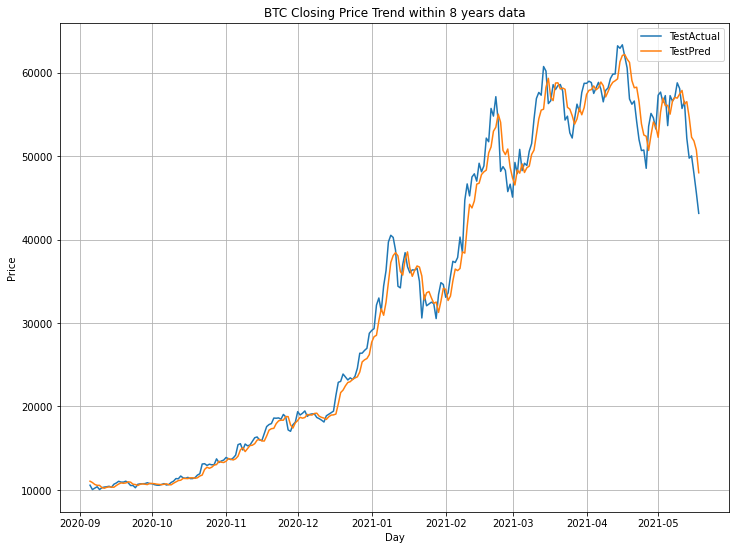

In [ ]:
# Visualize the actual and prediction
offset=300
plt.figure(figsize=(12,9))
plot_timeseries_data(X_test[-len(test_windows):],
                     test_labels.flatten(),
                     format="-",
                     start=offset,
                     label="TestActual")
plot_timeseries_data(X_test[-len(test_windows):],
                     model_1_pred,
                     start=offset,
                     format="-",
                     label="TestPred")

### Model 2 - Dense: 30W1H

In [ ]:
WINDOWS_SIZE = 30
HORIZON_SIZE = 1

full_windows, full_labels = create_windows(data.values.flatten(),window_size=WINDOWS_SIZE,horizon=HORIZON_SIZE)
train_windows,train_labels,test_windows,test_labels = make_train_test_split(full_windows,full_labels)

In [ ]:
len(train_windows),len(test_labels)

(2205, 552)

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON_SIZE,), # no need a activation function because it is like regression prooblem               
],name="model_2_dense")

model_2.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])

In [ ]:
model_2.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data = (test_windows,test_labels),
    callbacks = [make_model_checkpoint("model_2_dense")]
)

INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_2_dense/model_experiments/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
model_2.evaluate(
    test_windows,
    test_labels
    )
model_2 = tf.keras.models.load_model("model_2_dense/model_experiments")
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 609.9871 - mae: 609.9871 - mse: 1256973.8750


[609.987060546875, 609.987060546875, 1256973.875]

In [ ]:
model_2_pred = make_preds(model_2,test_windows)
model_2_result = evaluate_preds(test_labels,model_2_pred)
model_2_result

{'mae': 17231.17945159588,
 'mape': 113.86687110152984,
 'mase': 30.120268244212152,
 'mse': 618493094.4517057,
 'rmse': 23812.521990400106}

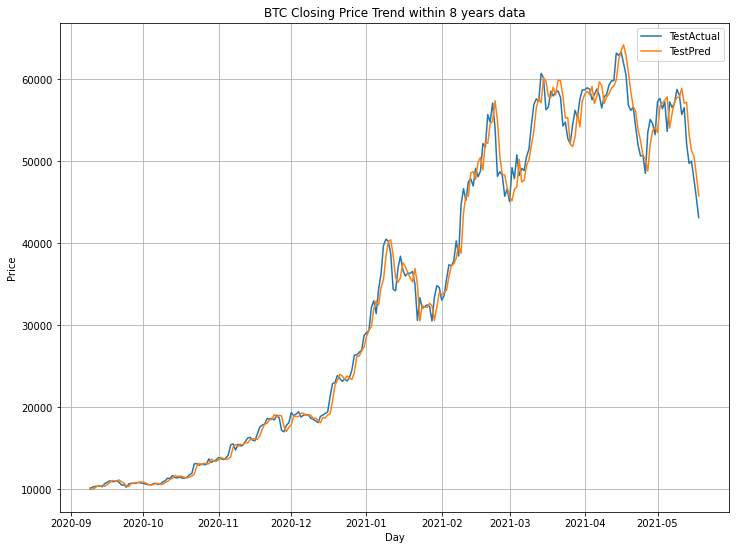

In [ ]:
# Visualize the actual and prediction
offset=300
plt.figure(figsize=(12,9))
plot_timeseries_data(X_test[-len(test_windows):],
                     test_labels.flatten(),
                     format="-",
                     start=offset,
                     label="TestActual")
plot_timeseries_data(X_test[-len(test_windows):],
                     model_2_pred,
                     start=offset,
                     format="-",
                     label="TestPred")

### Model 3 - Dense: 30W7H

In [ ]:
WINDOWS_SIZE = 30
HORIZON_SIZE = 7

full_windows, full_labels = create_windows(data.values.flatten(),window_size=WINDOWS_SIZE,horizon=HORIZON_SIZE)
train_windows,train_labels,test_windows,test_labels = make_train_test_split(full_windows,full_labels)

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON_SIZE,), # no need a activation function because it is like regression prooblem               
],name="model_3_dense")

model_3.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])

In [ ]:
model_3.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data = (test_windows,test_labels),
    callbacks = [make_model_checkpoint("model_3_dense")]
)

INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: model_3_dense/model_experiments/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
model_3.evaluate(
    test_windows,
    test_labels
    )
model_3 = tf.keras.models.load_model("model_3_dense/model_experiments")
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1253.3870 - mae: 1253.3870 - mse: 5446413.0000


[1253.386962890625, 1253.386962890625, 5446413.0]

In [ ]:
model_3_pred = make_preds(model_3,test_windows)
model_3_result = evaluate_preds(test_labels,model_3_pred.numpy())
model_3_result

{'mae': 1253.3869773192391,
 'mape': 5.616919509254426,
 'mase': 2.230331872180961,
 'mse': 5446412.4861084735,
 'rmse': 1439.6825121029099}

In [ ]:
test_labels.shape,model_3_pred.numpy()

((551, 7), array([[ 9327.416,  9476.3  ,  9439.729, ...,  9259.054,  9484.567,
          9346.226],
        [ 8973.088,  9178.975,  9195.594, ...,  9117.995,  9151.698,
          9083.73 ],
        [ 8848.993,  9047.955,  8971.228, ...,  9055.141,  9132.322,
          8987.427],
        ...,
        [57854.42 , 58429.18 , 58192.99 , ..., 57039.066, 58006.977,
         57152.85 ],
        [57338.14 , 59231.88 , 58985.89 , ..., 57378.33 , 58180.35 ,
         57851.75 ],
        [56352.34 , 58020.4  , 57320.34 , ..., 57571.19 , 57505.4  ,
         57549.938]], dtype=float32))

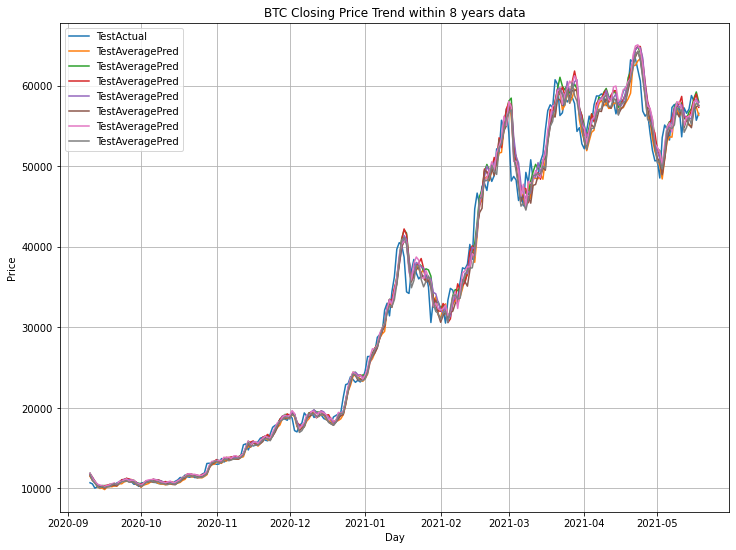

In [ ]:
# Visualize the actual and prediction
offset=300
plt.figure(figsize=(12,9))
plot_timeseries_data(X_test[-len(test_windows):],
                     test_labels[:,0],
                     format="-",
                     start=offset,
                     label="TestActual")
plot_timeseries_data(X_test[-len(test_windows):],
                     model_3_pred, # 7 horizon, will overlap 7 kind of plot for this one
                     start=offset,
                     format="-",
                     label="TestAveragePred")

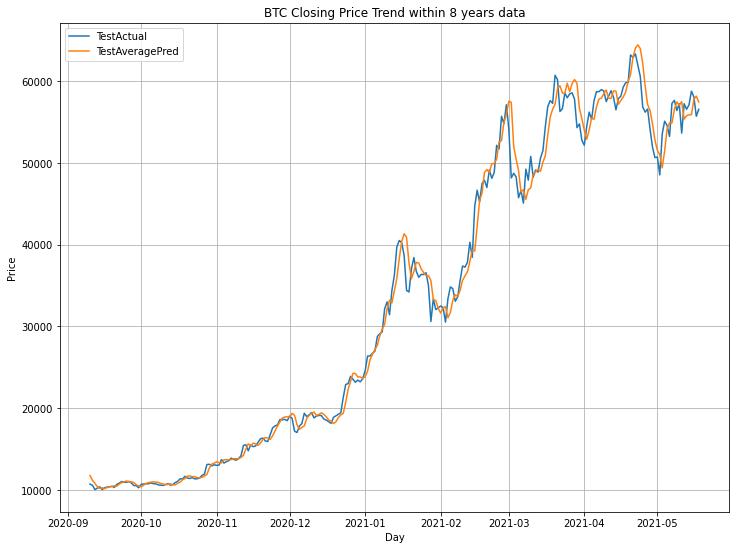

In [ ]:
# Visualize the actual and prediction
offset=300
plt.figure(figsize=(12,9))
plot_timeseries_data(X_test[-len(test_windows):],
                     test_labels[:,0],
                     format="-",
                     start=offset,
                     label="TestActual")
plot_timeseries_data(X_test[-len(test_windows):],
                     #model_3_pred,
                     tf.reduce_mean(model_3_pred,axis=1), # reduce mean in order to plot the chat for horizon > 1
                                        # so the data might missing some part
                     start=offset,
                     format="-",
                     label="TestAveragePred")

### Compare Model Performance
- AutoCorrelation
  - the relationship about the same variable between successive timestamp

In [ ]:
model_performance_df = pd.DataFrame([{
    "naive": model_0_result["mae"],
    "model_1":model_1_result["mae"],
    "model_2":model_2_result["mae"],
    "model_3":model_3_result["mae"]
}]).T.reset_index()
model_performance_df.rename({0:"mae"},inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


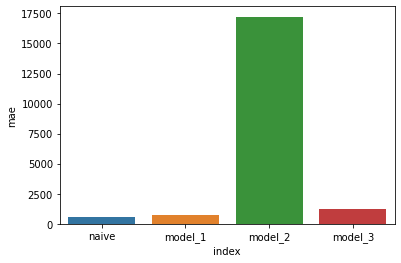

In [ ]:
sns.barplot(model_performance_df["index"],model_performance_df["mae"])

## 2022.07.18 - TimeSeries Part 3 - BitPred
- Timeseries multivariatee
[0,1,2,3,4,5,6,7,other_variable] -> [8]

### Model 4 - Conv1D
- can also be applied to sequence problem like sentiment analysis or timeseries forcasting problem
- the input shape need to be (batch_size,timestemp,input_dim)
- layer.lambda: define customized Transformation in the NN network

In [ ]:
HORIZON_SIZE = 1
WINDOW_SIZE = 7
full_windows,full_labels = create_windows(data.values.flatten(),WINDOW_SIZE,HORIZON_SIZE)
train_windows,train_labels,test_windows,test_labels = make_train_test_split(full_windows,full_labels)

In [ ]:
# layer.lambda, udf transfrormation in the neural network
expand_dim_layer = tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1))
expand_dim_layer(train_windows[0])

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[123.65499],
       [125.455  ],
       [108.58483],
       [118.67466],
       [121.33866],
       [120.65533],
       [121.795  ]], dtype=float32)>

In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1)),
    tf.keras.layers.Conv1D(128,kernel_size=5,activation="relu",padding="causal"),
    tf.keras.layers.Dense(HORIZON_SIZE,activation="linear") 
],name="model_4_conv1d")

model_4.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
history_4 = model_4.fit(
    train_windows,
    train_labels,
    epochs=1,
    batch_size=128,
    validation_data = (test_windows,test_labels),
    verbose=0,
    callbacks = [make_model_checkpoint("model_4_Conv1d")]
)

INFO:tensorflow:Assets written to: model_4_Conv1d/model_experiments/assets


INFO:tensorflow:Assets written to: model_4_Conv1d/model_experiments/assets


In [ ]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_29 (Lambda)          (None, 1, 7)              0         
                                                                 
 conv1d_21 (Conv1D)          (None, 1, 128)            4608      
                                                                 
 dense_40 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 2320.5461 - mae: 2320.5461 - mse: 13062850.0000


[2320.546142578125, 2320.546142578125, 13062850.0]

In [ ]:
model_4_pred = make_preds(model_4,test_windows)
model_4_result = evaluate_preds(tf.squeeze(test_labels),model_4_pred)
model_4_result

{'mae': 624.1891750497102,
 'mape': 2.830450073297298,
 'mase': 1.0965273815138556,
 'mse': 1271775.5553268825,
 'rmse': 1127.7302670970937}

### Model 5 - LSTM

In [ ]:
HORIZON_SIZE = 1
WINDOW_SIZE = 7
full_windows,full_labels = create_windows(data.values.flatten(),WINDOW_SIZE,HORIZON_SIZE)
train_windows,train_labels,test_windows,test_labels = make_train_test_split(full_windows,full_labels)

In [ ]:
tf.random.set_seed(42)

inputs = tf.keras.layers.Input(shape=[WINDOW_SIZE])
x = tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.LSTM(128,activation="relu")(x)
outputs = tf.keras.layers.Dense(HORIZON_SIZE)(x)
model_5 = tf.keras.Model(inputs,outputs,name="model_5_lstm")

model_5.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])

In [ ]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 7)]               0         
                                                                 
 lambda_30 (Lambda)          (None, 1, 7)              0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               69632     
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_5 = model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data = (test_windows,test_labels),
    verbose=0,
    callbacks = [make_model_checkpoint("model_5_LSTM")]
)

INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


INFO:tensorflow:Assets written to: model_5_LSTM/model_experiments/assets


In [ ]:
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 594.9866 - mae: 594.9866 - mse: 1259464.8750


[594.986572265625, 594.986572265625, 1259464.875]

In [ ]:
model_5_pred = make_preds(model_5,test_windows)
model_5_result = evaluate_preds(tf.squeeze(test_labels),model_5_pred)
model_5_result

{'mae': 594.9865209672392,
 'mape': 2.6880216196703675,
 'mase': 1.0452264120413288,
 'mse': 1259464.901629388,
 'rmse': 1122.2588389624686}

In [ ]:
{'mae': 594.9865209672392,
 'mape': 2.6880216196703675,
 'mase': 1.0452264120413288,
 'mse': 1259464.901629388,
 'rmse': 1122.2588389624686}

### Model 6 - Multivariate Dense
- can add on more feature from 
  - https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving
  - can add on block reward might be a potential factor impact the price in the future

#### Feature Engineerinng

In [ ]:
bw1 = 50
bw2 = 25
bw3 = 12.5
bw4 = 6.25

bwd2 = np.datetime64("2012-11-28")
bwd3 = np.datetime64("2016-07-09")
bwd4 = np.datetime64("2020-05-18")

In [ ]:
np.datetime64("2022-01-01") < bwd3

False

In [ ]:
def gen_block_rewards(row):
  if row < bwd3:
    return bw2
  elif row >= bwd3 and row < bwd4:
    return bw3
  else:
    return bw4

In [ ]:
mv_data = data.copy().reset_index()
mv_data["BlockRewards"] = mv_data["Date"].apply(gen_block_rewards)
mv_data.set_index("Date",inplace=True)

In [ ]:
mv_data.head()

,Price,BlockRewards
Date,,
2013-10-01,123.65499,25.0
2013-10-02,125.45500,25.0
2013-10-03,108.58483,25.0
2013-10-04,118.67466,25.0
2013-10-05,121.33866,25.0


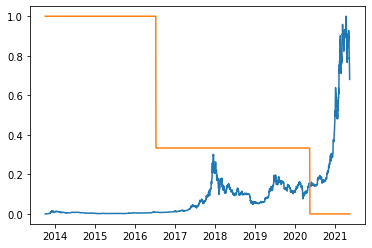

In [ ]:
from sklearn.preprocessing import minmax_scale
plt.plot(mv_data.index,minmax_scale(mv_data))

#### Create Multivariate windows and horizon
- from tensorflow.keras.utils import timeseries_dataset_from_array
- pandas shift

In [ ]:
HORIZON_SIZE = 1
WINDOW_SIZE = 7

mv_data = data.copy().reset_index()
mv_data["BlockRewards"] = mv_data["Date"].apply(gen_block_rewards)
mv_data.set_index("Date",inplace=True)

for i in range(7):
  mv_data[f"Price_{i}"] = mv_data[f"Price"].shift(periods=i+1)

mv_data.dropna(inplace=True)

In [ ]:
full_windows = mv_data.drop("Price",axis=1)
full_labels = mv_data["Price"].to_frame()

In [ ]:
full_labels

NameError: ignored

In [ ]:
prop = 0.8
split_size = int(prop*len(full_windows))
train_windows, train_labels = full_windows[:split_size], full_labels[:split_size]
test_windows, test_labels = full_windows[split_size:], full_labels[split_size:]

In [ ]:
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows.shape

(2224, 8)

In [ ]:
tf.random.set_seed(42)
model_6 = tf.keras.Sequential(
    [
     tf.keras.layers.Dense(128,activation="relu"),
     tf.keras.layers.Dense(HORIZON_SIZE)
    ],name="model_6_dense_multivariate"
)

model_6.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                optimizer = tf.keras.optimizers.Adam())

In [ ]:
history_6 = model_6.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data = (test_windows,test_labels),
    verbose=0,
    callbacks = [make_model_checkpoint("model_6_dense_multivariate")]
)

INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


INFO:tensorflow:Assets written to: model_6_dense_multivariate/model_experiments/assets


In [ ]:
model_6.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 645.7142


645.7142333984375

In [ ]:
model_6_pred = make_preds(model_6,test_windows)
model_6_result = evaluate_preds(tf.squeeze(test_labels),model_6_pred)
model_6_result

{'mae': 645.7143245459495,
 'mape': 2.967411706016076,
 'mase': 1.134341103310498,
 'mse': 1322403.419189433,
 'rmse': 1149.9580075765518}

## 2022.07.19 - TimeSeries Part 4 - BitPred

### N-BEAST algorithm
- https://arxiv.org/abs/1905.10437

### Create Customized Layer - OO
- Architecture:
  - model -> Stack -> Block -> FC layer in stack
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#methods
- univariate timecasting

In [ ]:
class NBeatBlocks(tf.keras.layers.Layer):
  def __init__(self,
               inputs_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super(NBeatBlocks,self).__init__(**kwargs) # can take other opt arg to the parent's ctor
    self.inputs_size = inputs_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    
    self.hidden = [tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation="linear",name="theta")

  # will be executed when model executing
  def call(self,inputs):
    x = inputs
    for la in self.hidden:
      x = la(x)
    theta = self.theta_layer(x)
    backcast,forecast = theta[:,:self.inputs_size], theta[:,-1*self.horizon:]
    return backcast, forecast

### Testing on Customized Layer

In [ ]:
tf.random.set_seed(42)
WINDOW_SIZE = 7
HORIZON = 1
dummy_data = tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0)
nbeast_block_layer = NBeatBlocks(inputs_size = WINDOW_SIZE,
                                 theta_size = WINDOW_SIZE+HORIZON, # make sure the output size is enough to split and get right WINDOWS_SIZE and HORIZON
                                 horizon = HORIZON,
                                 n_neurons=512,
                                 n_layers=4
                                 )

In [ ]:
bc,fc = nbeast_block_layer(dummy_data)

### Convert Data to tf.Data
- For fast loading

In [ ]:
ts_data = data.copy()
for i in range(WINDOW_SIZE):
  ts_data[f"Price_{i+1}"] = ts_data["Price"].shift(periods=i+1)


X = ts_data.dropna().drop("Price",axis=1)
Y = ts_data.dropna()["Price"].to_numpy()

In [ ]:
split_ind = int(0.8*len(X))
full_windows,full_labels = X,Y
train_windows,train_labels = X[:split_ind],Y[:split_ind]
test_windows,test_labels = X[split_ind:],Y[split_ind:]
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows

,Price_1,Price_2,Price_3,Price_4,Price_5,Price_6,Price_7
Date,,,,,,,
2013-10-08,121.795000,120.655330,121.338660,118.674660,108.584830,125.455000,123.654990
2013-10-09,123.033000,121.795000,120.655330,121.338660,118.674660,108.584830,125.455000
2013-10-10,124.049000,123.033000,121.795000,120.655330,121.338660,118.674660,108.584830
2013-10-11,125.961160,124.049000,123.033000,121.795000,120.655330,121.338660,118.674660
2013-10-12,125.279660,125.961160,124.049000,123.033000,121.795000,120.655330,121.338660
...,...,...,...,...,...,...,...
2019-11-05,9202.415451,9290.896602,9197.632345,9131.410630,9225.995479,9455.724693,9458.223360
2019-11-06,9369.628081,9202.415451,9290.896602,9197.632345,9131.410630,9225.995479,9455.724693
2019-11-07,9326.599624,9369.628081,9202.415451,9290.896602,9197.632345,9131.410630,9225.995479


In [ ]:
### Hyperr parameter in the paper
BATCH_SIZE=1024

full_windows_dataset = tf.data.Dataset.from_tensor_slices(full_windows)
full_labels_dataset = tf.data.Dataset.from_tensor_slices(full_labels)
full_dataset = tf.data.Dataset.zip(datasets=(full_windows_dataset,full_labels_dataset)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


train_windows_dataset = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip(datasets=(train_windows_dataset,train_labels_dataset)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


test_windows_dataset = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset = tf.data.Dataset.zip(datasets=(test_windows_dataset,test_labels_dataset)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Set up a Hyper Parameter
- Speed up data input pipeline like fe pipeline
- Set up the experimental hyper parameter: based on the papers

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

N_EPOCHS = 5000 
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30 # this is 30 stacks and one block for each stacks

# lookback period. tthat is the windows size that you want to use to take into your tsmodel
# pass ? days as input 
# in paper: 2H, 3H, .... 7H
INPUT_SIZE = WINDOW_SIZE * HORIZON

THETA_SIZE = WINDOW_SIZE + HORIZON

### Residual Connection
- the output of some layers in the stack layer will be the ***additional added*** input of the other non-subsequent layer in the stack
- Resnet/LSTM for example.
  - tf-supported-func: layer and layer add or substraction
  - implemented inside the stack of N-BEAST

In [ ]:
a_tensor = tf.range(8)
b_tensor = tf.range(8)

# lower_case -> calculation
# upper_case -> layer operation
tf.keras.layers.add([a_tensor,b_tensor])

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([ 0,  2,  4,  6,  8, 10, 12, 14], dtype=int32)>

## 2022.07.20 - TimeSeries Part 5 - BitPred

### Model 7 - N-BEAST Model
- whole model only have 1 stack

In [ ]:
INPUT_SIZE, THETA_SIZE, HORIZON, N_NEURONS, N_LAYERS

(7, 8, 1, 512, 4)

In [ ]:
### Create model
tf.random.set_seed(42)
nbeast_block_model = NBeatBlocks(
    INPUT_SIZE,
    THETA_SIZE,
    HORIZON,
    N_NEURONS,
    N_LAYERS,
    name="nbeast_block_model_initial"
)

# finish the first stack
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE))
backcast, forecast = nbeast_block_model(stack_input)
residual = tf.keras.layers.subtract([stack_input,backcast]);

# finish the remaining stack
for i,_ in enumerate(range(N_STACKS-1)):
  backcast,forecast_block = NBeatBlocks(
    INPUT_SIZE,
    THETA_SIZE,
    HORIZON,
    N_NEURONS,
    N_LAYERS,
    name=f"nbeast_block_model_{i}"
  )(residual)
  residual = tf.keras.layers.subtract([residual,backcast],name=f"substract_{i}")
  forecast = tf.keras.layers.add([forecast,forecast_block],name=f"add_{i}")

model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,name="NBeastModel")

model_7.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics=["mae","mse"])

# monitor: val_loss will refer what loss function you defined in the model compile
# usually earlystopping patience will > reeduce lr patience
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=100,verbose=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=200,
                                                           restore_best_weights=True)


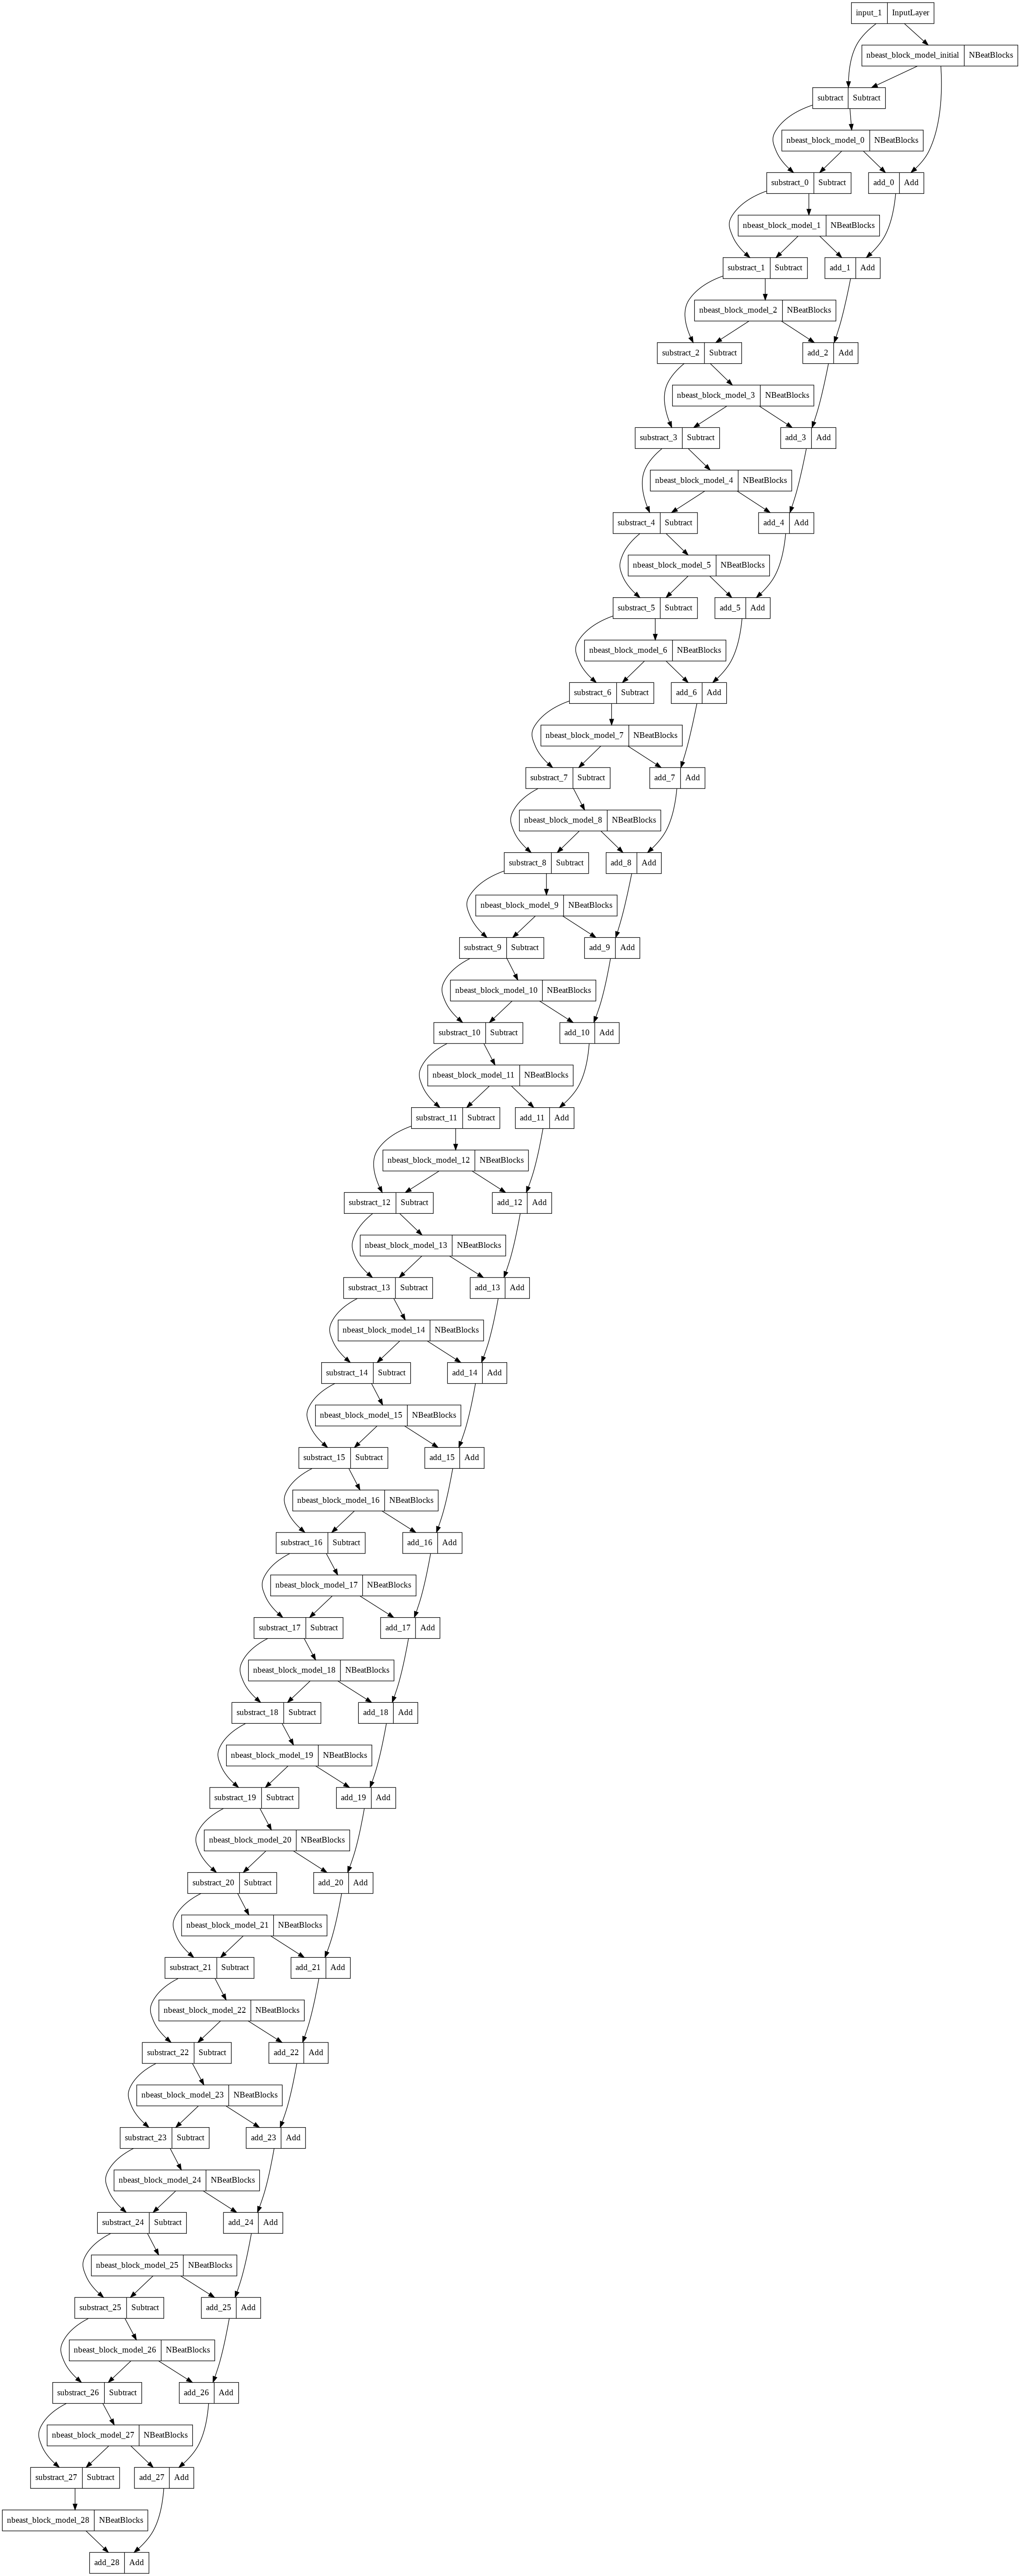

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [ ]:
%%time
history_7 = model_7.fit(train_dataset,
                        epochs=N_EPOCHS,
                        validation_data=test_dataset,
                        verbose=1,
                        callbacks=[reduce_lr_callback,early_stopping_callback])

Epoch 1/5000
3/3 [==============================] - 9s 809ms/step - loss: 39965.9531 - mae: 39965.9531 - mse: 4996361216.0000 - val_loss: 7233.4648 - val_mae: 7233.4648 - val_mse: 94808264.0000 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 138ms/step - loss: 7403.8926 - mae: 7403.8926 - mse: 171561792.0000 - val_loss: 6883.1489 - val_mae: 6883.1489 - val_mse: 84197512.0000 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 121ms/step - loss: 723.7312 - mae: 723.7312 - mse: 2335495.5000 - val_loss: 1710.4189 - val_mae: 1710.4189 - val_mse: 8349193.0000 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 129ms/step - loss: 916.4897 - mae: 916.4897 - mse: 2513237.7500 - val_loss: 1270.1038 - val_mae: 1270.1038 - val_mse: 4289277.0000 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 122ms/step - loss: 554.9860 - mae: 554.9860 - mse: 920402.3750 - val_loss: 1091.4781 - val_mae: 1091.4781 - val_mse: 3721936.0000 - lr: 

In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 37ms/step - loss: 576.7856 - mae: 576.7856 - mse: 1141763.6250


[576.78564453125, 576.78564453125, 1141763.625]

In [ ]:
model_7_pred = make_preds(model_7,test_dataset)
model_7_result = evaluate_preds(tf.squeeze(test_labels),model_7_pred)

In [ ]:
model_7_result

{'mae': 576.7856568979704,
 'mape': 2.655196325826561,
 'mase': 1.0132525383874393,
 'mse': 1141763.7990683059,
 'rmse': 1068.5334805556192}

### Model 8 - Ensemble Model
- Combine different model to predict a common goal
  - but training/prediction time might be longer
- one model with different loss function
- or different model with same loss function
- Notes.
  - can use kerrnel initializer: he_normal for example for weights initialization

In [ ]:
def get_ensemble_model_all(train_data,
                        horizon = 1,
                        num_iters = 10,
                        epochs=1000,
                        loss_func = ["mae","mse","mape"]):
  """
  30 models in total: 10 * 3 kind of loss function with same model
  """
  ensemble_model = []
  for i in range(num_iters):
    for loss_fn in loss_func:
      print(f"Model-{i} with loss_func:{loss_fn} for epochs {epochs}")
    
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
          tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
          tf.keras.layers.Dense(horizon) # no need activation function, cause right not is to forcast a value not predict a category
      ])

      model.compile(loss=loss_fn,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])
      
      model.fit(train_data,
                epochs = epochs,
                validation_data = train_data,
                verbose=0,
                callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=100,verbose=1),
                           tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=200,restore_best_weights=True)])
      
      ensemble_model.append(model)
  return ensemble_model


In [ ]:
def get_ensemble_model(train_data,
                        test_data,
                        horizon = 1,
                        num_iters = 10,
                        epochs=1000,
                        loss_func = ["mae","mse","mape"]):
  """
  30 models in total: 10 * 3 kind of loss function with same model
  """
  ensemble_model = []
  for i in range(num_iters):
    for loss_fn in loss_func:
      print(f"Model-{i} with loss_func:{loss_fn} for epochs {epochs}")
    
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
          tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
          tf.keras.layers.Dense(horizon) # no need activation function, cause right not is to forcast a value not predict a category
      ])

      model.compile(loss=loss_fn,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae","mse"])
      
      model.fit(train_data,
                epochs = epochs,
                validation_data = test_data,
                verbose=0,
                callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=100,verbose=1),
                           tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=200,restore_best_weights=True)])
      
      ensemble_model.append(model)
  return ensemble_model


In [ ]:
full_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
ensemble_model_all = get_ensemble_model_all(full_dataset,horizon=1,num_iters=5)

In [ ]:
ensemble_model = get_ensemble_model(train_dataset,test_dataset,horizon=1,num_iters=5)

In [ ]:
len(ensemble_model)

15

## 2022.07.21 - TimeSeries Part 6 - BitPred

In [ ]:
### Exercise, Ensemble prediction on the future dataset
total_prediction = []
for m in ensemble_model_all:
  ensemble_pred = get_future_prediction(y_all,m,7,14)
  total_prediction.append(ensemble_pred)

In [ ]:
ensemble_all_future_pred = np.array(total_prediction)
lower_all,upper_all = get_pred_interval(ensemble_all_future_pred)

In [ ]:
feature_ts_arr = pd.date_range(data.index[-1],periods=15)[1:]
feature_ts_arr

DatetimeIndex(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
               '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
               '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
               '2021-05-31', '2021-06-01'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
len(total_prediction[0])

14

In [ ]:
np.median(ensemble_all_future_pred,axis=0)

array([56595.996, 52312.1  , 49240.074, 49756.664, 47654.758, 45867.97 ,
       44647.766, 56463.17 , 52359.277, 49427.14 , 49988.28 , 47561.863,
       46598.25 , 45769.727], dtype=float32)

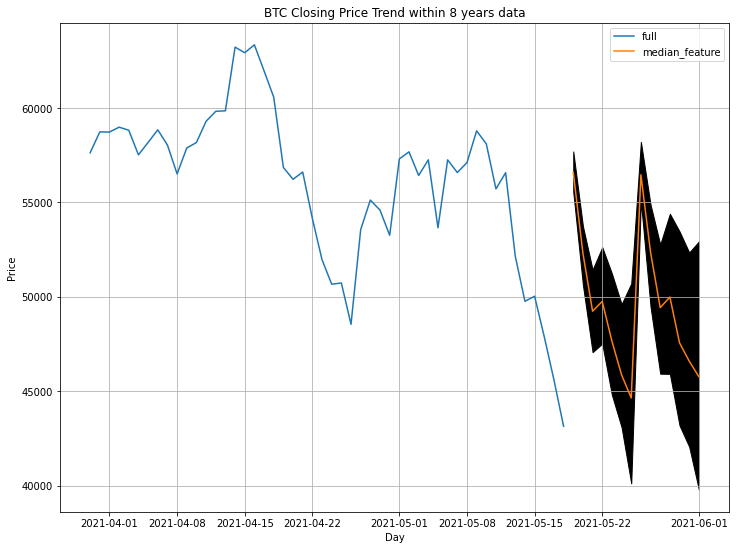

In [ ]:
plt.figure(figsize=(12,9))
plot_timeseries_data(data.index,data.values,start=-50,format="-",label="full")
plot_timeseries_data(feature_ts_arr,np.median(ensemble_all_future_pred,axis=0),format="-",label="median_feature")
plt.fill_between(feature_ts_arr,
                 lower_all,
                 upper_all,label="pred_interval",
                 color="black")

### Model_8 ensemble Model Evaluation
- Combine Regression Predictions
  - mean/median

In [ ]:
def make_ensemble_preds(models,data):
  # 1*15*556 and remove 1
  ensemble_preds = []
  for m in models:
    ensemble_pred = make_preds(m,data)
    ensemble_preds.append(ensemble_pred)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_model,test_dataset)

In [ ]:
ensemble_result_raw = evaluate_preds(test_labels,ensemble_preds)
ensemble_result_raw

{'mae': 579.6964837512731,
 'mape': 2.6536766054662024,
 'mase': 1.0183660544096262,
 'mse': 1183387.225147125,
 'rmse': 1087.621600316022}

In [ ]:
ensemble_preds_mean = tf.reduce_mean(ensemble_preds,axis=0)
ensemble_result_mean = evaluate_preds(test_labels,ensemble_preds_mean)
ensemble_result_mean

{'mae': 567.3406713008901,
 'mape': 2.581535308335743,
 'mase': 0.9966603164470673,
 'mse': 1147689.2459513375,
 'rmse': 1071.3025930853232}

In [ ]:
ensemble_preds_median = np.median(ensemble_preds,axis=0)
ensemble_result_median = evaluate_preds(test_labels,ensemble_preds_median)
ensemble_result_median 

{'mae': 564.9051056654855,
 'mape': 2.5806290839721906,
 'mase': 0.9923817026622598,
 'mse': 1140903.5395323148,
 'rmse': 1068.1308625502377}

### Prediction Interval
- when we saying prediction of forcasting, it is unreasonable to predict value, usually will be a range that include that predicted value. usually use 95% confidence interval. but which value we choose as base value => can use random value from across predictions for each tinmestamps

In [ ]:
def get_pred_interval(preds):
  pred_mean = tf.reduce_mean(preds,axis=0) # get mean on each timestamp

  # assume the dist for each timestamp is normal distribution
  # +-1.96 std will include 95% confidence interval 
  pred_std_95 = 1.96*tf.math.reduce_std(preds, axis=0)

  lower,upper = pred_mean - pred_std_95, pred_mean + pred_std_95
  
  return lower,upper

  

In [ ]:
lower_bound,upper_bound = get_pred_interval(ensemble_preds)

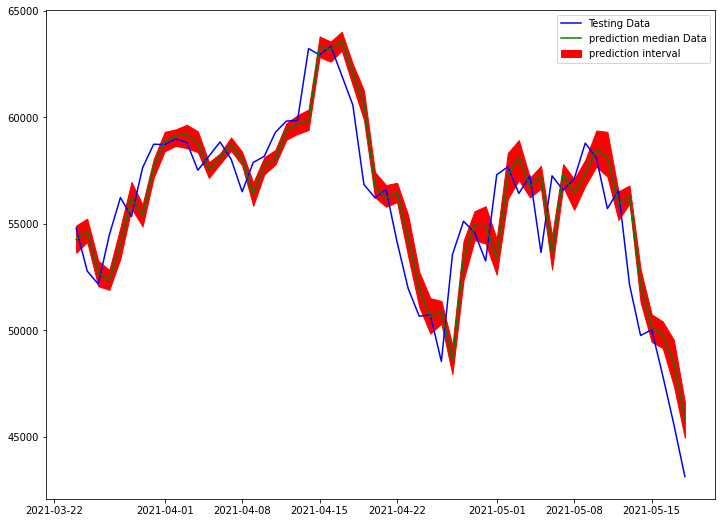

In [ ]:
plt.figure(figsize=(12,9))
offset = 500

plt.plot(test_windows.index[offset:],test_labels[offset:],"-",c="blue",label="Testing Data")
plt.plot(test_windows.index[offset:],ensemble_preds_median[offset:],c="green",label="prediction median Data")
plt.fill_between(test_windows.index[offset:],
                 lower_bound[offset:],
                 upper_bound[offset:],
                 label="prediction interval",color="red")
plt.legend()

### Two types of Uncertainty
- Aleatoric Uncertainty(Data/Subway) : uncertainty cannot be reduced with more data
  - bitcoin case. must exist some noise you cannot control
- Epsitemic Uncertainty(Model/coconut) : uncertainty can be reduced with more data

### Model 9 - Train All with Dense

In [ ]:
ts_data = data.copy()
WINDOW_SIZE = 7
HORIZON = 1
for i in range(WINDOW_SIZE):
  ts_data[f"Price_{i+1}"] = ts_data["Price"].shift(periods=i+1)


X_all = ts_data.dropna().drop("Price",axis=1)
y_all = ts_data.dropna()["Price"].to_numpy()

In [ ]:
X_all_windows = tf.data.Dataset.from_tensor_slices(X_all)
y_all_labels = tf.data.Dataset.from_tensor_slices(y_all)
train_dataset = tf.data.Dataset.zip((X_all_windows,y_all_labels)).batch(1024).prefetch(tf.data.AUTOTUNE)

In [ ]:
len(X_all)

2780

In [ ]:
model_9 = tf.keras.Sequential([
   tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
   tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
   tf.keras.layers.Dense(HORIZON)                               
])

model_9.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])


In [ ]:
history_9 = model_9.fit(train_dataset,
                        epochs=100,
                        verbose=0,
                        )

In [ ]:
model_9.evaluate(train_dataset)

3/3 [==============================] - 0s 5ms/step - loss: 1035.7048 - mae: 1035.7048 - mse: 4390237.0000


[1035.704833984375, 1035.704833984375, 4390237.0]

## 2022.07.22 - TimeSeries Part 7 - BitPred


### Model 9 prediction
- need to retrain the model if the actual value is appeae in the future timestamp
- but now we're using the prediction as input and predict further future output
  - Take initial input for initial prediction
  - predict the input with take-in model
  - update the input with the prediction
  - move window to update the latest prediction and keep windows size 
  - then keep above 4 steps until reach amount of INTO_FEATURE

In [ ]:
### 
INTO_FUTURE = 14 # 14 weeks prediction

def get_future_prediction(values,model,window_size=WINDOW_SIZE,into_feature=INTO_FUTURE):
  forcast_future = []

  last_window = values[-window_size:]

  for _ in range(into_feature):

    feature_pred = tf.squeeze(model.predict(tf.expand_dims(last_window,axis=0)))
    print(f"{last_window} => {feature_pred.numpy()}")

    forcast_future.append(feature_pred.numpy())

    last_window = np.append(last_window,feature_pred.numpy())[-window_size:] # get the latest window with window size

  return forcast_future


In [ ]:
actual_data = pd.read_csv("BTC-USD.csv")
actual_data = actual_data["Close"].values # 14 days since 2021-05-19

In [ ]:
actual_data

array([37002.441406, 40782.738281, 37304.691406, 37536.632813,
       34770.582031, 38705.980469, 38402.222656, 39294.199219,
       38436.96875 , 35697.605469, 34616.066406, 35678.128906,
       37332.855469, 36684.925781])

In [ ]:
y_all

array([  123.033     ,   124.049     ,   125.96116   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

In [ ]:
forcast_14_futures = get_future_prediction(y_all,
                       model_9)
forcast_14_futures

[56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] => 47480.45703125
[52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 47480.45703125] => 41257.83984375
[49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 47480.45703125 41257.83984375] => 43635.0390625
[50032.69313676 47885.62525472 45604.61575361 43144.47129086
 47480.45703125 41257.83984375 43635.0390625 ] => 38713.43359375
[47885.62525472 45604.61575361 43144.47129086 47480.45703125
 41257.83984375 43635.0390625  38713.43359375] => 44309.95703125
[45604.61575361 43144.47129086 47480.45703125 41257.83984375
 43635.0390625  38713.43359375 44309.95703125] => 34690.34765625
[43144.47129086 47480.45703125 41257.83984375 43635.0390625
 38713.43359375 44309.95703125 34690.34765625] => 41640.58984375
[47480.45703125 41257.83984375 43635.0390625  38713.43359375
 44309.95703125 34690.34765625 41640.58984375] => 35448.117

[47480.457,
 41257.84,
 43635.04,
 38713.434,
 44309.957,
 34690.348,
 41640.59,
 35448.117,
 41127.223,
 32924.99,
 38780.793,
 34528.25,
 34545.246,
 32787.895]

In [ ]:
pred_future_interval = pd.date_range(start="2021-05-19",periods=INTO_FUTURE)
pred_future_interval

DatetimeIndex(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
               '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
               '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
               '2021-05-31', '2021-06-01'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
y_all

array([  123.033     ,   124.049     ,   125.96116   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

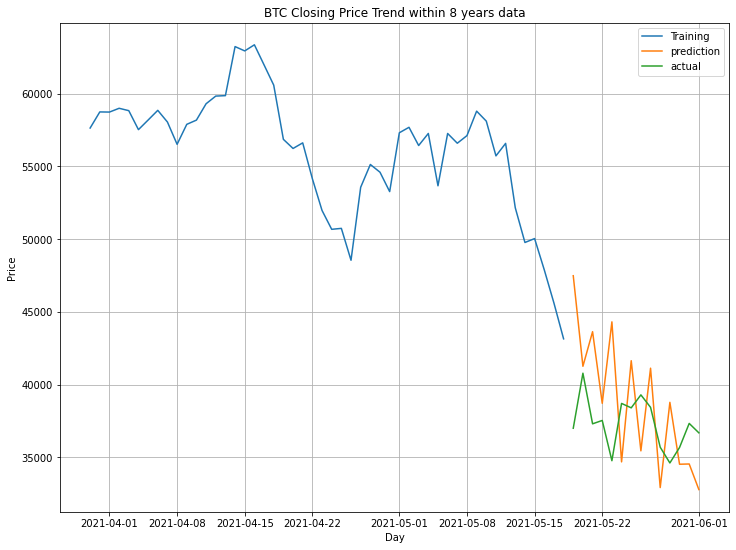

In [ ]:
plt.figure(figsize=(12,9))
plot_timeseries_data(data.index,y_all,format='-',start=-50,label="Training")
plt.plot(pred_future_interval,forcast_14_futures,label="prediction")
plt.plot(pred_future_interval,actual_data,label="actual")
plt.legend()

### Model 10 - Turkey Problem
- the future is unpredictable
- might be the data point might straight go down to zero or go up to really high value one day
- the model cannot predict the value out of distribution of trainning dataset that was trained on

### Prepare Turkey Dataset

In [ ]:
turkey_data = data.copy()
turkey_data.iloc[-1,0] /= 100 

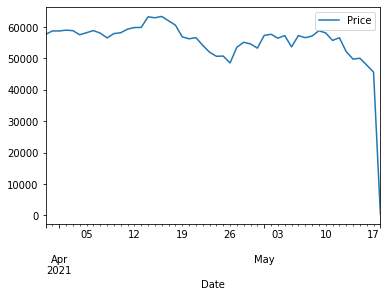

In [ ]:
turkey_data[-50:].plot()

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
X,y = create_windows(turkey_data.values.flatten())
X_train,y_train,X_test,y_test = make_train_test_split(X,y)

In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test)

(2224, 2224, 556, 556)

In [ ]:
model_10 = tf.keras.models.clone_model(model_1)
model_10._name="model_10_turkey"
model_10.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics=["mae","mse"])

In [ ]:
history_10 = model_10.fit(X_train,
             y_train,
             epochs=100,
             verbose=0,
             validation_data=(X_test,y_test),
             batch_size=128)

In [ ]:
model_10.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 645.3949 - mae: 645.3949 - mse: 4913594.5000


[645.3948974609375, 645.3948974609375, 4913594.5]

In [ ]:
model_10_pred = make_preds(model_10,X_test)
model_10_result = evaluate_preds(tf.squeeze(y_test),model_10_pred)
model_10_result

{'mae': 645.3948509824864,
 'mape': 21.58993837450662,
 'mase': 0.998750675953588,
 'mse': 4913594.564574575,
 'rmse': 2216.6629343620502}

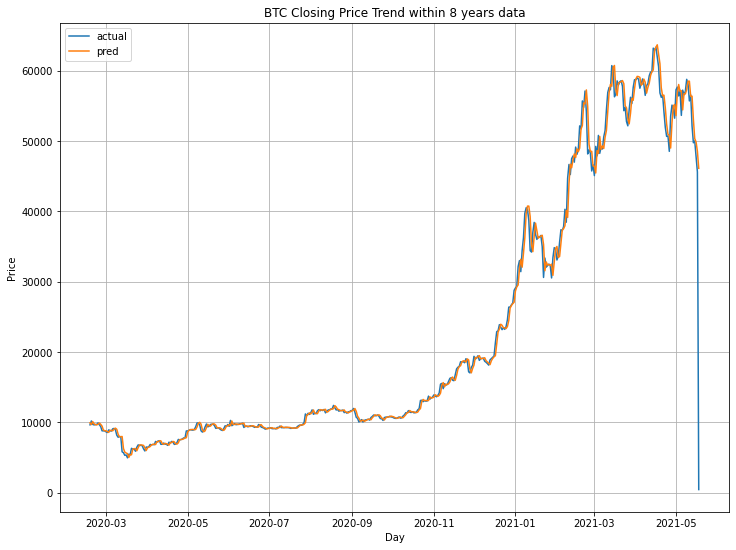

In [ ]:
offset = 100
plt.figure(figsize=(12,9))
plot_timeseries_data(turkey_data.index[-len(X_test):],y_test[-len(X_test):],start=offset,format="-",label="actual")
plot_timeseries_data(turkey_data.index[-len(X_test):],model_10_pred[-len(X_test):],start=offset,format="-",label="pred")

## Review

In [13]:
# Download the dataset
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
data = pd.read_csv(
    "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
    ,parse_dates=["Date"], # convert Date col to datetime type
    index_col=["Date"])# let Date as index
data = data.rename({data.columns[1]:"Price"},axis=1)["Price"].to_frame()

--2022-07-29 13:55:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-07-29 13:55:51 (11.1 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2’ saved [178509/178509]



In [107]:
# another dataset
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-07-29 14:18:31--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.007s  

2022-07-29 14:18:31 (8.93 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [115]:
temp_data = pd.read_csv(
    "/tmp/daily-min-temperatures.csv"
    ,parse_dates=["Date"], # convert Date col to datetime type
    index_col=["Date"])# let Date as index
#temp_data = data.rename({data.columns[1]:"Temp"},axis=1)["Temp"].to_frame()

In [152]:
WINDOW_SIZE = 2
HORIZON = 1
ts_data = data.copy()
ts_data = temp_data.copy()

In [153]:
col_name = "Temp"
for i in range(WINDOW_SIZE):
  ts_data[f"{col_name}_{i+1}"] = ts_data[col_name].shift(periods=i+1) 
ts_data.dropna(inplace=True)
# split train test 
X = ts_data.drop(col_name,axis=1).to_numpy()
y = ts_data[col_name].to_numpy()

In [154]:
split_size = int((1-0.2)*len(X))
X_train,y_train = np.expand_dims(X[:split_size],-1),y[:split_size]
X_test,y_test = np.expand_dims(X[split_size:],-1), y[split_size:]

In [155]:
X_train.shape

(2918, 2, 1)

In [156]:
X_train[0],y_train[0]

(array([[17.9],
        [20.7]]), 18.8)

In [157]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [100]:
#x = windowed_dataset(data["Price"].to_numpy(),7,1,1)

In [158]:
# tensorflow dataset

BATCH_SIZE = 128
train_data_set = tf.data.Dataset.from_tensor_slices(X_train)
train_label = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_data_set,train_label)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_data_set = tf.data.Dataset.from_tensor_slices(X_test)
test_label = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_data_set,test_label)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [159]:
len(train_dataset)

23

In [160]:
tf.random.set_seed(42)
model = tf.keras.models.Sequential([                                              
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1,activation="linear"),
])

In [161]:
model.compile(loss = tf.keras.losses.MeanAbsoluteError(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["mse"])

In [162]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data = test_dataset)

Epoch 1/100
23/23 [==============================] - 4s 43ms/step - loss: 10.6686 - mse: 130.1947 - val_loss: 10.0274 - val_mse: 116.6836
Epoch 2/100
23/23 [==============================] - 0s 8ms/step - loss: 7.0750 - mse: 68.8029 - val_loss: 4.4116 - val_mse: 29.3533
Epoch 3/100
23/23 [==============================] - 0s 8ms/step - loss: 3.9195 - mse: 23.9193 - val_loss: 3.6583 - val_mse: 20.4874
Epoch 4/100
23/23 [==============================] - 0s 8ms/step - loss: 3.5309 - mse: 19.5417 - val_loss: 3.5648 - val_mse: 19.3262
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 3.4136 - mse: 18.3262 - val_loss: 3.4539 - val_mse: 17.9983
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 3.3078 - mse: 17.2283 - val_loss: 3.3686 - val_mse: 17.0029
Epoch 7/100
23/23 [==============================] - 0s 8ms/step - loss: 3.2211 - mse: 16.3442 - val_loss: 3.3076 - val_mse: 16.3250
Epoch 8/100
23/23 [==============================] - 0s 8ms/step

In [139]:
model.evaluate(test_dataset)

6/6 [==============================] - 0s 5ms/step - loss: 2.7779 - mse: 12.3844


[2.7778539657592773, 12.384427070617676]

In [140]:
model.save("fs.h5")

In [141]:
from google.colab import files
files.download("fs.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>